### Method1: 
- Training: human labeled data
- Testing: pseudo labeled data


## call "~/.local/bin/poetry" if poetry keyword not working on mac

In [2]:
import datetime
import geopandas
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
#local scripts

from scripts import veg_indices, utilities, plots
#from scripts.utilities import *

In [4]:
# cpied from learning_about-data.ipynb
BANDS_DICT = {   'B2': 'Blue',
            'B3': 'Green',
            'B4': 'Red',
            'B5': 'Red_Edge_1',
            'B6': 'Red_Edge_2',
            'B7': 'Red_Edge_3',
            'B8': 'NIR',
            'B8A': 'Red_Edge_4',
            'B11': 'SWIR_1',
            'B12': 'SWIR_2'}

BANDS = list(BANDS_DICT.keys())

In [5]:
NUMERIC_COLS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','RVI',
                'ARVI','PSSRa','NDI45','GNDVI','MCARI','IRECI','CIr','MTCI',
                'NDVIre','NIRv','EVI','NDTI','NDMI','MSI','GCI','NBRI','BSI',
                'NDWI','NDSI','NDVI','RVI_diff','ARVI_diff','PSSRa_diff',
                'NDI45_diff','GNDVI_diff','MCARI_diff','IRECI_diff','CIr_diff',
                'MTCI_diff','NDVIre_diff','NIRv_diff','EVI_diff','NDTI_diff',
                'NDMI_diff','MSI_diff','GCI_diff','NBRI_diff','BSI_diff','NDWI_diff',
                'NDSI_diff','NDVI_diff','RVI_prev','ARVI_prev','PSSRa_prev','NDI45_prev',
                'GNDVI_prev','MCARI_prev','IRECI_prev','CIr_prev','MTCI_prev','NDVIre_prev',
                'NIRv_prev','EVI_prev','NDTI_prev','NDMI_prev','MSI_prev','GCI_prev',
                'NBRI_prev','BSI_prev','NDWI_prev','NDSI_prev','NDVI_prev']

NUM_SAMPLES = 16

In [6]:
file_name = "merged_images_groundTruth"
df = geopandas.read_file(f'../data/{file_name}')

In [7]:

def get_ordered_rdm_forests_features():
    # first one is the most important
    return ['B4', 'B2', 'RVI', 'CIr', 'B3', 'NDVI', 'NDVIre', 'B5', 'NDI45',
       'MTCI_prev', 'IRECI', 'PSSRa', 'MTCI_diff', 'NDSI', 'NDWI', 'GNDVI',
       'ARVI', 'NDVIre_diff', 'NDMI_prev', 'NBRI_prev', 'ARVI_diff',
       'NDMI_diff', 'CIr_diff', 'MSI_prev', 'GNDVI_diff', 'NDWI_diff',
       'NIRv_prev', 'NBRI', 'B11', 'NDI45_prev', 'MTCI', 'B12', 'MSI_diff',
       'NDMI', 'NDI45_diff', 'BSI_diff', 'GCI', 'BSI_prev', 'NBRI_diff',
       'NDSI_diff', 'NDSI_prev', 'CIr_prev', 'BSI', 'ARVI_prev', 'NDTI_diff',
       'NDTI_prev', 'NIRv_diff', 'EVI', 'MCARI', 'EVI_prev', 'NDTI',
       'RVI_diff', 'MSI', 'MCARI_diff', 'B6', 'NDVI_prev', 'NDVIre_prev',
       'RVI_prev', 'IRECI_prev', 'PSSRa_prev', 'GCI_diff', 'IRECI_diff',
       'PSSRa_diff', 'NDVI_diff', 'MCARI_prev', 'B8A', 'EVI_diff', 'B7',
       'GCI_prev', 'B8', 'NIRv', 'NDWI_prev', 'GNDVI_prev']
    

SELECTED_FEATURES = ['NDVI', 'RVI', 'BSI', 'MCARI_prev', 'B4']
#SELECTED_FEATURES = NUMERIC_COLS
#SELECTED_FEATURES = train_df[SELECTED_FEATURES].dropna(axis=1).columns


#SELECTED_FEATURES = get_ordered_rdm_forests_features()[:5] # get top N features

print("selected features:", SELECTED_FEATURES)

def get_X_y(dataframe: pd.DataFrame):
    df_X = dataframe[SELECTED_FEATURES]
    #df_X = df_X.dropna(axis=1)
    X = df_X.to_numpy().reshape((df_X.shape[0], df_X.shape[1], 1))
    y = dataframe["har_evnt"].to_numpy().astype(np.float32)
    return X, y

selected features: ['NDVI', 'RVI', 'BSI', 'MCARI_prev', 'B4']


# Separate by Farm

In [8]:
from sklearn.model_selection import train_test_split

def separate_by_farm(df:pd.DataFrame):
    points_df_list = []
    for p in  df['point_idx'].unique(): # ['p0','p1','p2','p3','p4', ...]
        curr_df = df[df["point_idx"] == p]
        points_df_list.append(curr_df)
    len(points_df_list)

    training_df_list, validation_df_list = train_test_split(points_df_list, train_size=0.8, random_state=42)

    print(len(training_df_list))
    print(len(validation_df_list))

    # combine into two dataframes
    train_df = pd.concat(training_df_list)
    validate_df = pd.concat(validation_df_list)
    print(train_df.shape, validate_df.shape)
    
    return train_df, validate_df

validate_df, train_df = separate_by_farm(df)
test_df = validate_df

443
111
(1347, 85) (335, 85)


# Random Upsampling

In [9]:
#%%script echo skipping
def apply_random_upsampling(df):
    har_evnt_true_df = df[df["har_evnt"]]
    har_evnt_false_df = df[df["har_evnt"] == False]
    print(har_evnt_true_df.shape)
    print(har_evnt_false_df.shape)

    from sklearn.utils import resample

    upsampled_har_evnt_true_df = resample(har_evnt_true_df, n_samples=har_evnt_false_df.shape[0],
                                                    replace=True, random_state=42)
    print(upsampled_har_evnt_true_df.shape)

    return pd.concat([upsampled_har_evnt_true_df, har_evnt_false_df])
    print(df.shape)

train_df = apply_random_upsampling(train_df)

(60, 85)
(275, 85)
(275, 85)


# Convert to Numpy

In [10]:
X_train, y_train = get_X_y(train_df)
print(X_train.shape, y_train.shape)

X_validate, y_validate = get_X_y(validate_df)
print(X_validate.shape, y_validate.shape)

X_test, y_test = get_X_y(test_df)
print(X_test.shape, y_test.shape)

(550, 5, 1) (550,)
(1347, 5, 1) (1347,)
(1347, 5, 1) (1347,)


In [11]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

model = tf.keras.Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', 
            input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    BatchNormalization(),
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 64)                2

In [13]:
metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()] # because imbalanced data
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

In [14]:

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

filepath = 'my_best_model.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_precision', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_validate, y_validate), callbacks=[earlyStopping, checkpoint])

Epoch 1/200


2023-05-27 19:37:15.380414: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/18 [>.............................] - ETA: 6s - loss: 0.6916 - precision: 0.5217 - recall: 0.8000
Epoch 1: val_precision improved from inf to 0.18708, saving model to my_best_model.hdf5
18/18 [==============================] - 1s 10ms/step - loss: 0.6466 - precision: 0.6781 - recall: 0.7891 - val_loss: 0.7307 - val_precision: 0.1871 - val_recall: 1.0000
Epoch 2/200
 1/18 [>.............................] - ETA: 0s - loss: 0.5764 - precision: 0.7647 - recall: 0.7647
Epoch 2: val_precision did not improve from 0.18708
18/18 [==============================] - 0s 3ms/step - loss: 0.5551 - precision: 0.7222 - recall: 0.7564 - val_loss: 0.7609 - val_precision: 0.1872 - val_recall: 1.0000
Epoch 3/200
 1/18 [>.............................] - ETA: 0s - loss: 0.4045 - precision: 0.9412 - recall: 0.8421
Epoch 3: val_precision did not improve from 0.18708
18/18 [==============================] - 0s 2ms/step - loss: 0.5210 - precision: 0.7233 - recall: 0.7891 - val_loss: 0.7701 - val_precision: 0

In [15]:
model = tf.keras.models.load_model(filepath)

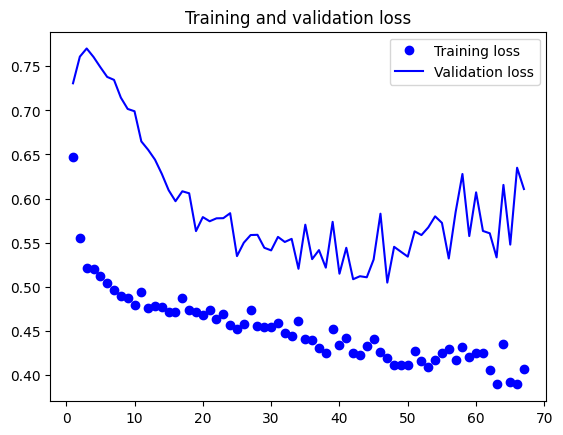

In [16]:
import matplotlib.pyplot as plt

#acc = history.history['binary_accuracy']
#val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
import sklearn
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


def plot_confusion_matrix(actual, predicted):
    print(metrics.confusion_matrix(actual, predicted))
    confusion_matrix = metrics.confusion_matrix(actual, predicted, normalize='true')

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    


In [18]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

def get_prediction_nn(X_in, model):
    y_predict = np.array(list(model.predict(X_in)))
    y_predict = y_predict.reshape(y_predict.shape[0])
    return y_predict

def evaluate(X_in: np.ndarray, y_in:np.array, y_predict:np.array, threshold:int=None) -> int:
    if not threshold:
        thresholds = np.arange(0, 1, 0.001) # define thresholds
        # evaluate each threshold
        scores = [metrics.f1_score(y_in, to_labels(y_predict, t)) for t in thresholds]
        idx = np.argmax(scores)
        threshold = thresholds[idx]
        print("F1 Score:", scores[idx])
    print("Threshold:", threshold)
    func = np.vectorize(lambda x: 0 if x < threshold else 1)
    print(np.unique(func(y_predict), return_counts=True))
    print(sklearn.metrics.classification_report(y_in, func(y_predict)))
    plot_confusion_matrix(y_in, func(y_predict))
    
    return threshold

X_train
18/18 [==============================] - 0s 469us/step
F1 Score: 0.7580372250423012
Threshold: 0.534
(array([0, 1]), array([234, 316]))
              precision    recall  f1-score   support

         0.0       0.78      0.67      0.72       275
         1.0       0.71      0.81      0.76       275

    accuracy                           0.74       550
   macro avg       0.75      0.74      0.74       550
weighted avg       0.75      0.74      0.74       550

[[183  92]
 [ 51 224]]


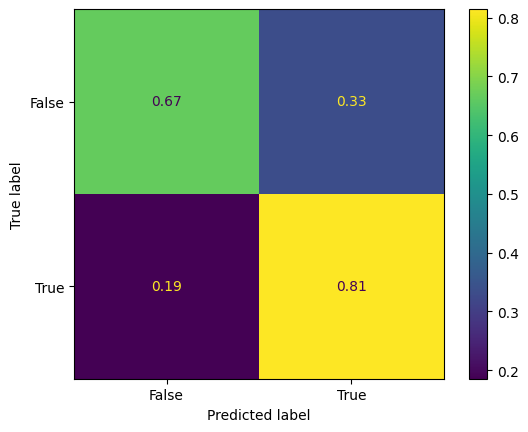

0.534

In [19]:
print("X_train")
evaluate(X_train, y_train, get_prediction_nn(X_train, model))

X_validate
43/43 [==============================] - 0s 1ms/step
F1 Score: 0.5406203840472674
Threshold: 0.536
(array([0, 1]), array([922, 425]))
              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85      1095
         1.0       0.43      0.73      0.54       252

    accuracy                           0.77      1347
   macro avg       0.68      0.75      0.69      1347
weighted avg       0.83      0.77      0.79      1347

[[853 242]
 [ 69 183]]


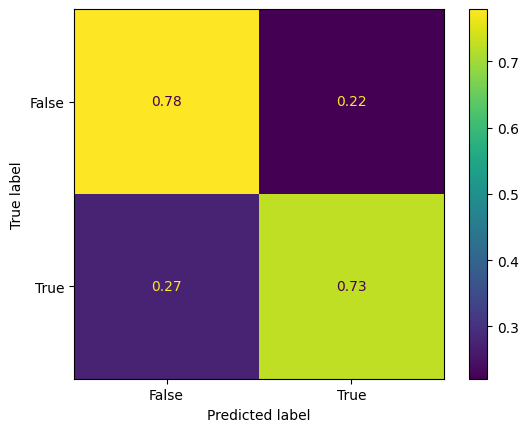

0.536

In [20]:
print("X_validate")
evaluate(X_validate, y_validate, get_prediction_nn(X_validate, model))

X_test
43/43 [==============================] - 0s 409us/step
F1 Score: 0.5406203840472674
Threshold: 0.536
(array([0, 1]), array([922, 425]))
              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85      1095
         1.0       0.43      0.73      0.54       252

    accuracy                           0.77      1347
   macro avg       0.68      0.75      0.69      1347
weighted avg       0.83      0.77      0.79      1347

[[853 242]
 [ 69 183]]


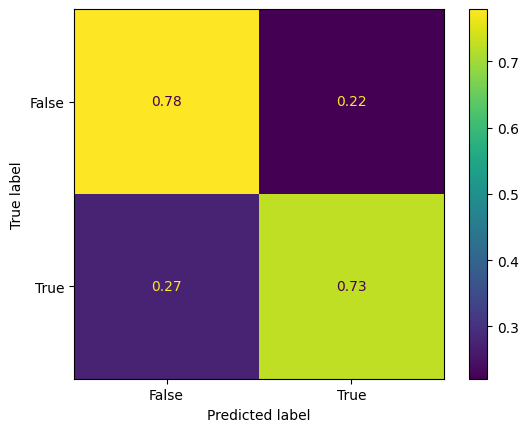

In [21]:
print("X_test")
threshold = evaluate(X_test, y_test, get_prediction_nn(X_test, model))

1/1 [==============================] - 0s 15ms/step
F1 Score: 0.7317073170731707
Threshold: 0.001
(array([0, 1]), array([162, 281]))
              precision    recall  f1-score   support

         0.0       0.65      0.55      0.59       191
         1.0       0.69      0.77      0.73       252

    accuracy                           0.68       443
   macro avg       0.67      0.66      0.66       443
weighted avg       0.67      0.68      0.67       443

[[105  86]
 [ 57 195]]


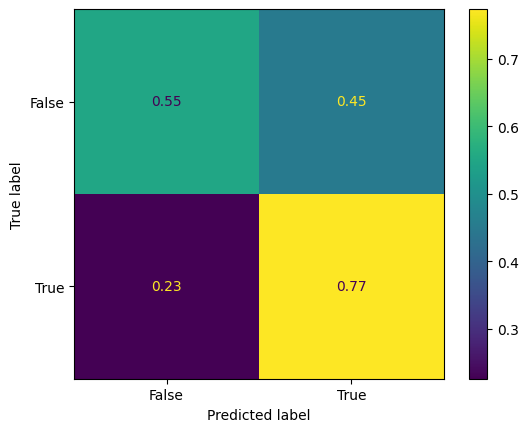

In [22]:
def predict_by_farm():
    farm_level_prediction = []
    farm_level_true_labels = []
    #for i in range(7, 11 + 1):
    for i in np.unique(test_df.point_idx):
        bools = test_df["point_idx"] == i
        curr_X_test = X_test[bools]
        curr_y_test = y_test[bools]
                
        curr_y_predict = get_prediction_nn(curr_X_test, model)
        func = np.vectorize(lambda x: 0 if x < threshold else 1)
        
        true_label = max(curr_y_test)
        predicted_label = max(func(curr_y_predict))
        
        farm_level_true_labels.append(true_label)
        farm_level_prediction.append(predicted_label)
    
    evaluate(None, farm_level_true_labels, farm_level_prediction)

predict_by_farm()

# Random Forests Feature Selection

In [23]:


def rm_extradim(X, y):
    X, y = X.reshape(X.shape[0], X.shape[1]), y.reshape(y.shape[0])
    return X, y
    

X_train, y_train = rm_extradim(X_train, y_train)
X_validate, y_validate = rm_extradim(X_validate, y_validate)
X_test, y_test = rm_extradim(X_test, y_test)
from sklearn.metrics import accuracy_score

import sklearn

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

X_train
F1 Score: 1.0
Threshold: 0.001
(array([0, 1]), array([275, 275]))
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       275
         1.0       1.00      1.00      1.00       275

    accuracy                           1.00       550
   macro avg       1.00      1.00      1.00       550
weighted avg       1.00      1.00      1.00       550

[[275   0]
 [  0 275]]


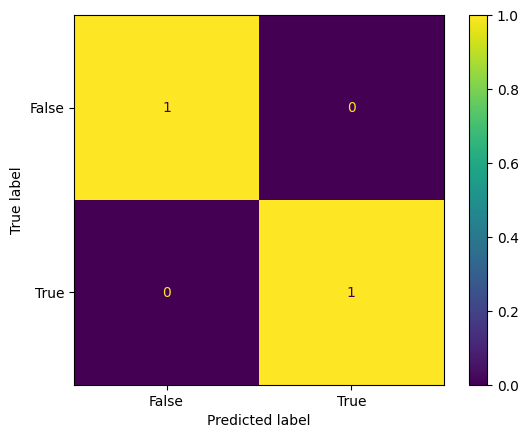

0.001

In [24]:
print("X_train")
y_predict = rf.predict(X_train)
evaluate(X_train, y_train, y_predict)

X_validate
F1 Score: 0.484725050916497
Threshold: 0.001
(array([0, 1]), array([1108,  239]))
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      1095
         1.0       0.50      0.47      0.48       252

    accuracy                           0.81      1347
   macro avg       0.69      0.68      0.68      1347
weighted avg       0.81      0.81      0.81      1347

[[975 120]
 [133 119]]


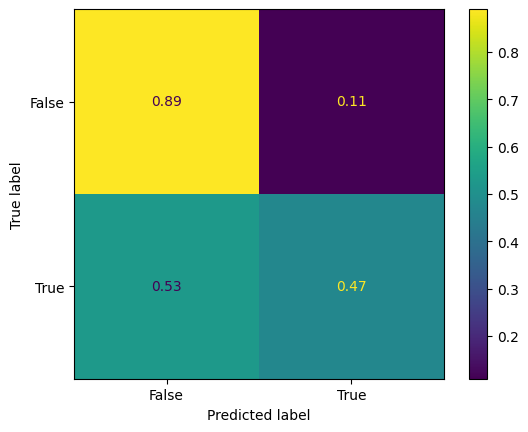

0.001

In [25]:
print("X_validate")
y_predict = rf.predict(X_validate)
evaluate(X_validate, y_validate, y_predict)

X_test
F1 Score: 0.484725050916497
Threshold: 0.001
(array([0, 1]), array([1108,  239]))
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      1095
         1.0       0.50      0.47      0.48       252

    accuracy                           0.81      1347
   macro avg       0.69      0.68      0.68      1347
weighted avg       0.81      0.81      0.81      1347

[[975 120]
 [133 119]]


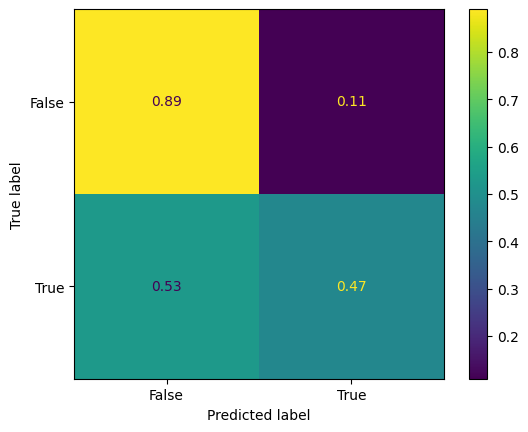

0.001

In [26]:
print("X_test")

y_predict = rf.predict(X_test)
evaluate(X_test, y_test, y_predict)

F1 Score: 0.7251798561151079
Threshold: 0.0
(array([1]), array([443]))
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       191
         1.0       0.57      1.00      0.73       252

    accuracy                           0.57       443
   macro avg       0.28      0.50      0.36       443
weighted avg       0.32      0.57      0.41       443

[[  0 191]
 [  0 252]]


/Users/tahaal/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-656nMzP8-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tahaal/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-656nMzP8-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tahaal/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-656nMzP8-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

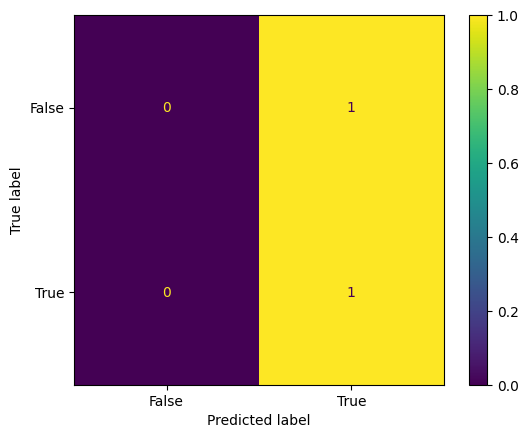

In [27]:
def predict_by_farm_rf():
    farm_level_prediction = []
    farm_level_true_labels = []
    #for i in range(7, 11 + 1):
    for i in np.unique(test_df.point_idx):
        bools = test_df["point_idx"] == i
        curr_X_test = X_test[bools]
        curr_y_test = y_test[bools]
                
        curr_y_predict = rf.predict(curr_X_test)
        func = np.vectorize(lambda x: 0 if x < threshold else 1)
        
        true_label = max(curr_y_test)
        predicted_label = max(func(curr_y_predict))
        
        farm_level_true_labels.append(true_label)
        farm_level_prediction.append(predicted_label)
    
    evaluate(None, farm_level_true_labels, farm_level_prediction)
threshold = 1
predict_by_farm_rf()

In [28]:
np.unique(y_test, return_counts=True)

(array([0., 1.], dtype=float32), array([1095,  252]))

In [29]:
feature_importances_df = pd.DataFrame(rf.feature_importances_,
                    index=SELECTED_FEATURES, 
                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_df

,importance
B4,0.266671
RVI,0.238931
NDVI,0.206088
BSI,0.170544
MCARI_prev,0.117765


In [30]:
feature_importances_df.T.columns

Index(['B4', 'RVI', 'NDVI', 'BSI', 'MCARI_prev'], dtype='object')

In [31]:
train_df

,level_0,INDEX,index,B11,B12,B2,B3,B4,B5,B6,...,NDTI_diff,NDMI_diff,MSI_diff,GCI_diff,NBRI_diff,BSI_diff,NDWI_diff,NDSI_diff,NDVI_diff,geometry
1072,797,p348,348,0.20380,0.14310,0.06000,0.09045,0.10275,0.16425,0.21730,...,-0.025489,-0.085704,0.126594,0.661430,-0.101104,0.139411,-0.106127,-0.199989,-0.015684,POINT (38.32713 48.90801)
1479,929,p493,493,0.35580,0.28820,0.29960,0.29240,0.26860,0.29170,0.33980,...,-0.102657,-0.097129,0.152570,-1.380114,-0.187607,-0.063605,0.297943,0.226874,-0.100720,POINT (33.94455 45.11922)
240,540,p70,70,0.30280,0.22680,0.06040,0.08960,0.13400,0.15880,0.17480,...,0.014208,-0.072026,0.203100,-0.126772,-0.059361,0.059740,0.022613,-0.033889,-0.058006,POINT (32.59422 46.18425)
1348,1351,p445,445,0.27620,0.21700,0.08920,0.10600,0.12860,0.14500,0.15310,...,0.020308,-0.027899,0.085194,-0.445013,-0.008339,-0.010481,0.103332,0.066285,-0.053727,POINT (39.01009 48.57657)
1061,1721,p344,344,0.28175,0.20255,0.08420,0.11110,0.14330,0.17420,0.20370,...,-0.027028,-0.035097,0.083888,-0.135710,-0.062689,0.004013,0.027686,-0.002857,0.010363,POINT (34.73830 46.04189)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,2367,p551,551,0.40240,0.36000,0.08230,0.10730,0.12570,0.16060,0.20655,...,0.018726,0.080178,-0.315976,0.325066,0.099785,-0.061641,-0.067622,0.006640,0.091577,POINT (34.01482 48.74033)
490,133,p153,153,0.16820,0.09670,0.04130,0.07780,0.05110,0.10950,0.26720,...,0.000132,-0.021645,0.024211,-0.476626,-0.016763,0.040551,0.031625,0.024507,-0.044880,POINT (39.40554 49.26040)
491,620,p153,153,0.23585,0.16345,0.06775,0.09295,0.13700,0.16680,0.18145,...,-0.088596,-0.371479,0.586581,-1.938619,-0.410672,0.395436,0.222251,-0.067131,-0.509976,POINT (39.40554 49.26040)
551,154,p178,178,0.24840,0.20520,0.04470,0.06550,0.09120,0.11740,0.15090,...,-0.018883,-0.152273,0.370408,0.121522,-0.172457,0.174238,-0.018241,-0.128660,-0.135079,POINT (31.42944 47.04558)


In [32]:
np.unique(y_test, return_counts=True)

(array([0., 1.], dtype=float32), array([1095,  252]))